In [ ]:
! nvidia-smi

Tue Sep  8 17:12:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wG8ebiWaE5f3g6NonW0UJ3n19xxhh8eYlCzh5Z5FP_0PzeHl3NuIsA
Mounted at /content/gdrive


In [ ]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 604.8MB 29kB/s 
     |████████████████████████████████| 6.5MB 25.3MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
import cv2
import pkgutil
import importlib
import os
import random
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
import seaborn as sns
sns.set()
print('Pytorch version:', torch.__version__)

Pytorch version: 1.5.1+cu92


In [ ]:
%%time
from zipfile import ZipFile
with ZipFile('/content/gdrive/My Drive/EVA4P2_S6_Zipdataset/EVA4P2_S6_GAN_Cars.zip', mode='r') as input:
  input.extractall('.')

CPU times: user 10.8 ms, sys: 2.04 ms, total: 12.9 ms
Wall time: 880 ms


In [ ]:
def prepare_data(root, classes):
  finaldata = []
  for i in range(len(classes)):
    path = root + '/' + classes[i] + '/'
    data_rec = [(path+file_name, i) for file_name in os.listdir(path)]
    finaldata.extend(data_rec) 
  random.shuffle(finaldata)
  return finaldata

In [ ]:
class_list       = [0]
class_names_dict = {0:'Cars'}
class_names      = ['Cars']

In [ ]:
dataset          = prepare_data('/content/Data',class_names)
print(f'Dataset Length:{len(dataset)}, Train Data length: {int(len(dataset)*1)}') 
train_len = int(len(dataset)*1)

Dataset Length:118, Train Data length: 118


In [ ]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase2

Cloning into 'Deep_Learning_EVA4_Phase2'...
remote: Enumerating objects: 609, done.
remote: Total 609 (delta 0), reused 0 (delta 0), pack-reused 609
Receiving objects: 100% (609/609), 21.35 MiB | 35.49 MiB/s, done.
Resolving deltas: 100% (323/323), done.


In [ ]:
%cd '/content/Deep_Learning_EVA4_Phase2/S6_GAN'
! ls

/content/Deep_Learning_EVA4_Phase2/S6_GAN
README.md  src


In [ ]:
os.chdir('/content/Deep_Learning_EVA4_Phase2/S6_GAN/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import customdataset as cds
from src.dataset import Alb_data_transforms as Alb
from src.losses  import Train_Losses
from src.losses  import Test_Losses

In [ ]:
import albumentations as A
channel_means  = (0.48043839, 0.44820218, 0.39760034)
channel_stdevs = (0.27698959, 0.26908774, 0.28216029)
# Train Phase transformations
train_transforms = Alb.Albumentations_transform([
                                      A.Resize(100, 100),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                    ])

In [ ]:
train = cds.Customdataset(dataset[:train_len],train_transforms)
print(f'Train Length {len(train)}')

Train Length 118


In [ ]:
train_loader  = DataLoader(train, batch_size = 32,shuffle = True, num_workers=4, pin_memory = True)

In [ ]:
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  #print(img.shape)
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i]) + channel_means[i]
  return np.transpose(img, (1,2,0))

In [ ]:
dataiter = iter(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


To check if images are coming out correctly as batches, images.shape: torch.Size([32, 3, 100, 100]), labels.shape: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


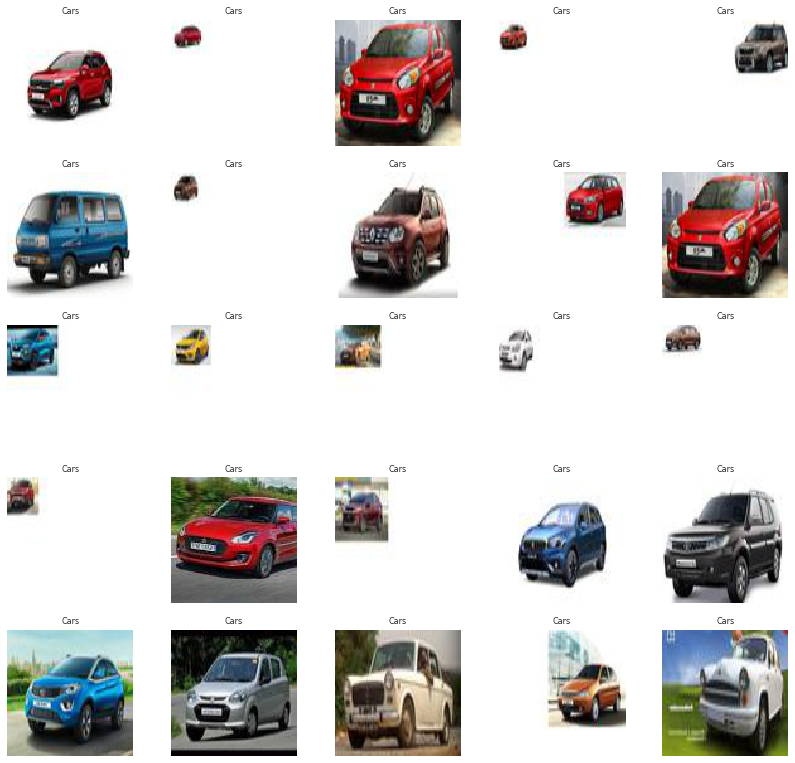

In [ ]:
images, labels = dataiter.next()
print(f'To check if images are coming out correctly as batches, images.shape: {images.shape}, labels.shape: {labels.shape}')
num_classes = len(class_names)
r, c = 5, 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.3)
for i in range(r):
  for j in range(c):
    idx = i*c + j
    ax  = plt.subplot(r,c, idx + 1)
    ax.set_title(class_names[labels[idx]][:30], fontdict={'fontsize':8})
    plt.axis('off')
    ax.imshow(unnormalize(images[idx]), interpolation ='none')
plt.show() 

In [ ]:
MODEL_NAME = 'DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
IMAGE_DIM = (32, 32, 3)

In [ ]:
def get_sample_image(G, n_noise):
    """
        save sample 10 images
    """
    z = torch.randn(10, n_noise).to(DEVICE)
    y_hat_prev = G(z)
    y_hat = G(z).view(10, 3, 100, 100).permute(0, 2, 3, 1)    #Modify axes to (10, 28, 28, 3) via permute
    result = (y_hat.detach().cpu().numpy()+1)/2.
    return result

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # Conv-1 -> 128 -> 64
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # Conv-2 -> 64 -> 32
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # Conv-3 -> 32 -> 16
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            # Conv-4 -> 16 -> 8
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            # Conv-5 -> 8 -> 4
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            # Conv-6 -> 4 -> 2
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
        )        
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x, y=None):
        y_ = F.interpolate(x, (128,128))
        y_ = self.conv(y_)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [ ]:
class Generator(nn.Module):
    def __init__(self, out_channel=1, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        assert IMAGE_DIM[0] % 2**4 == 0, 'Should be divided 16'
        self.init_dim = (IMAGE_DIM[0] // 2**4, IMAGE_DIM[1] // 2**4)
        self.fc = nn.Sequential(
            nn.Linear(input_size, self.init_dim[0]*self.init_dim[1]*512),
            nn.ReLU(),
        ) # 100 -> 2048
        self.conv = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # 2048 -> 2x2x512    
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 2x2x512 -> 4x4x256
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 4x4x256 -> 8x8x128
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 8x8x128 -> 16x16x128
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 16x16x128 -> 32x32x128
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 32x32x128 -> 64x64x128                       
            nn.ConvTranspose2d(128, out_channel, 4, stride=2, padding=1, bias=False),
            # 64x64x128 -> 128x128x3
            nn.Tanh(),
        )
        
    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.fc(x)
        y_ = y_.view(y_.size(0), 512, self.init_dim[0], self.init_dim[1])
        y_ = self.conv(y_)
        y_ = F.interpolate(y_, (100,100))  # 128x128x3 -> 100x100x3
        return y_

In [ ]:
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
D = Discriminator(in_channel=IMAGE_DIM[-1]).to(DEVICE)
G = Generator(out_channel=IMAGE_DIM[-1]).to(DEVICE)

In [ ]:
!pip install torchsummary
from torchsummary import summary

In [ ]:
summary(D, input_size=(3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 64, 64]          13,824
       BatchNorm2d-2          [-1, 512, 64, 64]           1,024
         LeakyReLU-3          [-1, 512, 64, 64]               0
            Conv2d-4          [-1, 256, 32, 32]       1,179,648
       BatchNorm2d-5          [-1, 256, 32, 32]             512
         LeakyReLU-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]         294,912
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 128, 8, 8]         147,456
      BatchNorm2d-11            [-1, 128, 8, 8]             256
        LeakyReLU-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 128, 4, 4]         147,456
      BatchNorm2d-14            [-1, 12

In [ ]:
z = torch.randn(batch_size, n_noise).to(DEVICE)

In [ ]:
z.shape

torch.Size([32, 100])

In [ ]:
summary(G, input_size=(1,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]         206,848
              ReLU-2                 [-1, 2048]               0
            Conv2d-3            [-1, 512, 2, 2]       2,359,296
       BatchNorm2d-4            [-1, 512, 2, 2]           1,024
              ReLU-5            [-1, 512, 2, 2]               0
   ConvTranspose2d-6            [-1, 256, 4, 4]       2,097,152
       BatchNorm2d-7            [-1, 256, 4, 4]             512
              ReLU-8            [-1, 256, 4, 4]               0
   ConvTranspose2d-9            [-1, 128, 8, 8]         524,288
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
  ConvTranspose2d-12          [-1, 128, 16, 16]         262,144
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

In [ ]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

In [ ]:
max_epoch = 10
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100
batch_size = 32

In [ ]:
for epoch in range(max_epoch):

    D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
    D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake
    last_batch = 0

    for idx, images in enumerate(train_loader):
        # Training Discriminator
        if int(images[0].shape[0]) < int(batch_size):
            D_labels = torch.ones([images[0].shape[0], 1]).to(DEVICE)  # Discriminator Label to real
            D_fakes  = torch.zeros([images[0].shape[0], 1]).to(DEVICE) # Discriminator Label to fake   
            last_batch = 1

        x = images[0].to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        if int(images[0].shape[0]) < int(batch_size):
            z = torch.randn(images[0].shape[0], n_noise).to(DEVICE)
        else:                   
            z = torch.randn(batch_size, n_noise).to(DEVICE)

        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            if int(images[0].shape[0]) < int(batch_size):
               z = torch.randn(images[0].shape[0], n_noise).to(DEVICE)
            else:                   
               z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0 or last_batch:
            print(f'Epoch: {epoch}/{max_epoch}, Step: {step}, D Loss: {D_loss.item():.6f}, G Loss: {G_loss.item():.6f}')
            G.eval()
            img = get_sample_image(G, n_noise)
            t = datetime.now()
            time_stamp = t.strftime("%Y")+t.strftime("%m")+t.strftime("%d")+t.strftime("%H")+t.strftime("%M")+t.strftime("%S")
            imsave(f'/content/gdrive/My Drive/EVA4P2_S6_Training/Images_D0908/DCGAN_{epoch}_{step:05d}_{time_stamp}.jpg', img[0])
            G.train()
        step += 1  

Epoch: 0/10, Step: 0, D Loss: 1.395909, G Loss: 0.835550
Epoch: 0/10, Step: 3, D Loss: 1.330469, G Loss: 0.822827
Epoch: 1/10, Step: 7, D Loss: 1.112190, G Loss: 0.960238
Epoch: 2/10, Step: 11, D Loss: 0.990190, G Loss: 1.052166
Epoch: 3/10, Step: 15, D Loss: 0.844935, G Loss: 1.127500
Epoch: 4/10, Step: 19, D Loss: 0.833541, G Loss: 1.163341
Epoch: 5/10, Step: 23, D Loss: 0.925606, G Loss: 1.130809
Epoch: 6/10, Step: 27, D Loss: 0.693585, G Loss: 1.250681
Epoch: 7/10, Step: 31, D Loss: 0.673826, G Loss: 1.307995
Epoch: 8/10, Step: 35, D Loss: 0.609738, G Loss: 1.364436
Epoch: 9/10, Step: 39, D Loss: 0.794080, G Loss: 1.309984


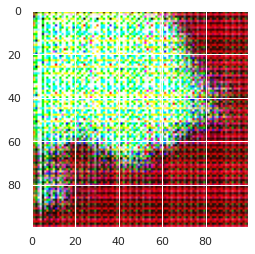

In [ ]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise)[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


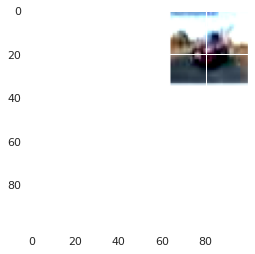

In [ ]:

# Real Image
t = Image.open(dataset[12][0])
t = (train_transforms(t).permute(1, 2, 0)+1)/2.
imshow(t)

In [ ]:
#path = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Stable_0730V3.pt'
#model.load_state_dict(torch.load(path))
path_stable_prev_save = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Stable_GPU_0808V1.pt'
model = torch.jit.load(path_stable_prev_save)